In [782]:
import pandas as pd
import numpy as np

In [783]:
care_df=pd.read_csv("./test/care.csv")

In [784]:
diagnosis_df=pd.read_csv("./test/diagnosis.csv")

In [785]:
patient_df=pd.read_csv("./test/patient.csv")

In [786]:
visit_df=pd.read_csv("./test/visit.csv")

In [787]:
risk_df=pd.read_csv("./train/risk.csv")

In [788]:
merged_df = pd.merge(diagnosis_df, risk_df, on='patient_id', how='inner')

In [789]:
care_df['care_count_per_patient'] = care_df.groupby('patient_id')['care_id'].transform('count')


In [790]:
care_df_new=care_df.drop('care_id',axis=1)

In [791]:
care_df_new=care_df.drop(['last_care_dt','next_care_dt'],axis=1)

In [792]:
care_df_new=care_df_new.drop('care_id',axis=1)

In [793]:
# Filter only LAB_TEST rows
lab_test_df = care_df_new[care_df_new['msrmnt_type'] == 'LAB TEST']

# Get all unique subtypes
subtypes = lab_test_df['msrmnt_sub_type'].unique()

# Create a column for each LAB_TEST subtype (1 if that subtype exists for the patient, else 0)
for subtype in subtypes:
    care_df_new[f'LAB_TEST_{subtype}'] = care_df_new.apply(
        lambda x: x['msrmnt_value'] if (x['msrmnt_type'] == 'LAB TEST' and x['msrmnt_sub_type'] == subtype) else 0,
        axis=1
    )
care_df_new

,patient_id,msrmnt_type,msrmnt_sub_type,msrmnt_value,care_gap_ind,care_count_per_patient,LAB_TEST_SYSTOLIC BLOOD PRESSURE,LAB_TEST_HbA1c,LAB_TEST_DIASTOLIC BLOOD PRESSURE
0,385,SCREENING,BREAST CANCER,0.0,t,1,0.0,0.0,0.0
1,804,SCREENING,COLORECTAL CANCER,0.0,t,1,0.0,0.0,0.0
2,1200,SCREENING,COLORECTAL CANCER,0.0,t,1,0.0,0.0,0.0
3,1300,SCREENING,COLORECTAL CANCER,0.0,t,1,0.0,0.0,0.0
4,3892,SCREENING,COLORECTAL CANCER,0.0,t,1,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
102,75411,SCREENING,BREAST CANCER,0.0,t,2,0.0,0.0,0.0
103,75411,SCREENING,COLORECTAL CANCER,0.0,t,2,0.0,0.0,0.0
104,76458,SCREENING,COLORECTAL CANCER,0.0,t,1,0.0,0.0,0.0
105,76638,SCREENING,COLORECTAL CANCER,0.0,t,1,0.0,0.0,0.0


In [794]:
# Separate LAB TEST rows
lab_test_rows = care_df_new[care_df_new['msrmnt_type'] == 'LAB TEST']

# Keep only non-lab rows for encoding
non_lab_rows = care_df_new[care_df_new['msrmnt_type'] != 'LAB TEST']

# Perform one-hot encoding on non-lab rows
encoded_df = pd.get_dummies(non_lab_rows, columns=['msrmnt_sub_type'], prefix='SUBTYPE')

# Combine back with LAB TEST rows
care_df_new = pd.concat([encoded_df, lab_test_rows], ignore_index=True)


In [795]:
care_df_new = care_df_new.drop(columns=['msrmnt_sub_type','msrmnt_type','msrmnt_value'])


In [796]:
cols = [
    'SUBTYPE_BREAST CANCER',
    'SUBTYPE_CHOLESTEROL',
    'SUBTYPE_COLORECTAL CANCER',
    'SUBTYPE_DIABETES',
    'SUBTYPE_HYPERTENSION'
]

care_df_new[cols] = care_df_new[cols].fillna(False)


/tmp/ipykernel_28417/3862260571.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  care_df_new[cols] = care_df_new[cols].fillna(False)


In [797]:
diagnosis_df['diagnosis_count_per_patient'] = diagnosis_df.groupby('patient_id')['diagnosis_id'].transform('count')

In [798]:
diagnosis_df = pd.get_dummies(diagnosis_df, columns=['condition_name'], prefix='COND')


In [799]:
diagnosis_df_new=diagnosis_df.drop(['diagnosis_id','condition_type','condition_description','is_chronic'],axis=1)

In [800]:
visit_counts = (
    visit_df
    .groupby(['patient_id', 'visit_type'])
    .size()
    .unstack(fill_value=0)
    .add_prefix('VISIT_')
    .reset_index()
)


In [801]:
# 1️⃣ Convert to datetime
visit_df['visit_start_dt'] = pd.to_datetime(visit_df['visit_start_dt'])
visit_df['visit_end_dt'] = pd.to_datetime(visit_df['visit_end_dt'])

# 2️⃣ Calculate number of days per visit
visit_df['visit_days'] = (visit_df['visit_end_dt'] - visit_df['visit_start_dt']).dt.days + 1

# 3️⃣ Get number of visits per patient per type
visit_counts = (
    visit_df
    .groupby(['patient_id', 'visit_type'])
    .size()
    .unstack(fill_value=0)
    .add_prefix('VISIT_COUNT_')
)

# 4️⃣ Get total days per patient per type
visit_days = (
    visit_df
    .groupby(['patient_id', 'visit_type'])['visit_days']
    .sum()
    .unstack(fill_value=0)
    .add_prefix('VISIT_DAYS_')
)

# 5️⃣ Merge both together
visit_summary = (
    visit_counts
    .merge(visit_days, left_index=True, right_index=True)
    .reset_index()
)


In [802]:
patient_conditions = (
    diagnosis_df_new.groupby('patient_id')[['COND_CANCER', 'COND_DIABETES', 'COND_HYPERTENSION']]
    .max()
    .assign(total_conditions=lambda x: x.sum(axis=1))
    .reset_index()
)


In [803]:
diagnosis_df_new=patient_conditions.drop('total_conditions',axis=1)

In [804]:
diagnosis_df_new = diagnosis_df_new.astype(int)


In [805]:
subtype_cols = [
    'SUBTYPE_BREAST CANCER',
    'SUBTYPE_CHOLESTEROL',
    'SUBTYPE_COLORECTAL CANCER',
    'SUBTYPE_DIABETES',
    'SUBTYPE_HYPERTENSION'
]


In [806]:
care_visits_per_patient = (
    care_df_new
    .groupby('patient_id')[subtype_cols]
    .sum()
    .reset_index()
)


In [807]:
lab_test_cols = [
    'LAB_TEST_HbA1c',
    'LAB_TEST_SYSTOLIC BLOOD PRESSURE',
    'LAB_TEST_DIASTOLIC BLOOD PRESSURE'
]

lab_test_avg = (
    care_df_new
    .groupby('patient_id')[lab_test_cols]
    .mean()
    .reset_index()
)


In [808]:
merged_df_care = pd.merge(care_visits_per_patient, lab_test_avg, on='patient_id', how='outer')


In [809]:
# Define columns
lab_test_cols = [
    'LAB_TEST_HbA1c',
    'LAB_TEST_SYSTOLIC BLOOD PRESSURE',
    'LAB_TEST_DIASTOLIC BLOOD PRESSURE'
]

subtype_cols = [
    'SUBTYPE_BREAST CANCER',
    'SUBTYPE_CHOLESTEROL',
    'SUBTYPE_COLORECTAL CANCER',
    'SUBTYPE_DIABETES',
    'SUBTYPE_HYPERTENSION'
]

# Create aggregation dictionary
agg_dict = {col: 'mean' for col in lab_test_cols}  # average lab tests
agg_dict.update({col: 'sum' for col in subtype_cols})  # sum subtype visits
agg_dict.update({'care_gap_ind': 'first', 'care_count_per_patient': 'first'})  # other columns

# Aggregate per patient
patient_summary = care_df_new.groupby('patient_id').agg(agg_dict).reset_index()


In [810]:
care_df_new=patient_summary.drop(['care_count_per_patient'],axis=1)

In [811]:
care_df_new['care_gap_ind'] = care_df_new['care_gap_ind'].map({'t': 1, 'f': 0})


In [812]:
cols_to_drop = [col for col in patient_df.columns if 'hot_spotter' in col]
patient_df_new = patient_df.drop(columns=cols_to_drop)


In [813]:
from functools import reduce

# List of your 4 dataframes
dfs = [care_df_new, diagnosis_df_new, patient_df_new, visit_summary]  # replace with your actual dataframe names

# Merge all dataframes on 'patient_id' using outer join
merged_df = reduce(lambda left, right: pd.merge(left, right, on='patient_id', how='outer'), dfs)

# Fill missing values with 0
merged_df = merged_df.fillna(0)


In [814]:
# Merge risk_df with merged_df on patient_id
final_df = pd.merge(merged_df, risk_df[['patient_id', 'risk_score']], on='patient_id', how='left')

# Optional: fill missing risk_score with 0 if some patients don't have a risk value
final_df['risk_score'] = final_df['risk_score'].fillna(0)


In [815]:
%pip install xgboost

import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [816]:
# Add a small constant to avoid log(0)
final_df['log_risk_score'] = np.log1p(final_df['risk_score'])


In [817]:
# Features
X = final_df.drop(columns=['patient_id', 'risk_score', 'log_risk_score'])
# Target (log-transformed)
y = final_df['log_risk_score']


In [818]:
import pandas as pd

# Ensure datetime
care_df['last_care_dt'] = pd.to_datetime(care_df['last_care_dt'])
care_df['next_care_dt'] = pd.to_datetime(care_df['next_care_dt'])

# Gap in days where both dates exist
care_df['care_gap_days'] = (care_df['next_care_dt'] - care_df['last_care_dt']).dt.days

# Indicator for having next care scheduled
care_df['has_next_care'] = care_df['next_care_dt'].notna().astype(int)

In [819]:
# Define 6-month period starting from the earliest date
visit_df['visit_start_dt'] = pd.to_datetime(visit_df['visit_start_dt'])
first_visit = visit_df.groupby('patient_id')['visit_start_dt'].min().reset_index()
first_visit = first_visit.rename(columns={'visit_start_dt': 'first_visit_dt'})
visit_df = visit_df.merge(first_visit, on='patient_id', how='left')
# 182 days ≈ 6 months
visit_df['period_6m'] = ((visit_df['visit_start_dt'] - visit_df['first_visit_dt']).dt.days // 182).astype(int)
freq_df = (
    visit_df
    .groupby(['patient_id', 'period_6m'])
    .size()
    .reset_index(name='visit_count')
)



In [820]:
# Pivot so each period becomes a column
freq_pivot = freq_df.pivot(index='patient_id', columns='period_6m', values='visit_count').fillna(0)

# Rename columns to meaningful names
freq_pivot.columns = [f'visit_count_6m_{col}' for col in freq_pivot.columns]

# Reset index to make patient_id a column
freq_pivot = freq_pivot.reset_index()


In [822]:
visit_df['visit_start_dt'] = pd.to_datetime(visit_df['visit_start_dt'], errors='coerce')
visit_df = visit_df.sort_values(['patient_id', 'visit_start_dt'])

# First visit per patient
first_visit = (
    visit_df.groupby('patient_id')['visit_start_dt']
    .min()
    .rename('first_visit_dt')
    .reset_index()
)

visit_df = visit_df.merge(first_visit, on='patient_id', how='left')

# Compute 6-month window index
visit_df['period_6m'] = ((visit_df['visit_start_dt'] - visit_df['first_visit_dt']).dt.days // 182)

# Keep only periods 0, 1, 2
visit_df = visit_df[visit_df['period_6m'].between(0, 2)]

# Count visits per 6-month window
freq_df = (
    visit_df
    .groupby(['patient_id', 'period_6m'])
    .size()
    .reset_index(name='visit_count')
)

# Pivot to columns visit_count_6m_0, visit_count_6m_1, visit_count_6m_2
freq_pivot = (
    freq_df
    .pivot(index='patient_id', columns='period_6m', values='visit_count')
    .fillna(0)
)

# Rename columns
freq_pivot.columns = [f'visit_count_6m_{int(col)}' for col in freq_pivot.columns]

# Ensure all 3 columns exist (fill missing)
for c in ['visit_count_6m_0', 'visit_count_6m_1', 'visit_count_6m_2']:
    if c not in freq_pivot.columns:
        freq_pivot[c] = 0

# Final tidy result
freq_pivot = freq_pivot.reset_index()


In [823]:
import pandas as pd

# Ensure datetime
visit_df['visit_start_dt'] = pd.to_datetime(visit_df['visit_start_dt'])

# Sort visits per patient
visit_df = visit_df.sort_values(by=['patient_id', 'visit_start_dt'])

# Compute gap between consecutive visits per patient
visit_df['prev_visit'] = visit_df.groupby('patient_id')['visit_start_dt'].shift(1)
visit_df['gap_days'] = (visit_df['visit_start_dt'] - visit_df['prev_visit']).dt.days

# Calculate average gap per patient
avg_gap = visit_df.groupby('patient_id')['gap_days'].mean().reset_index()
avg_gap = avg_gap.rename(columns={'gap_days': 'avg_visit_gap_days'})

# Fill NaN gaps (first visit) with 0 or leave as NaN if you prefer
avg_gap['avg_visit_gap_days'] = avg_gap['avg_visit_gap_days'].fillna(0)

print(avg_gap)


     patient_id  avg_visit_gap_days
0            95                37.0
1           168                 0.0
2           309                 0.0
3           333                 1.0
4           344                 0.0
..          ...                 ...
762       81531                 0.0
763       81844                86.0
764       81925               188.0
765       82069                 0.0
766       82163                 6.0

[767 rows x 2 columns]


In [824]:
# Merge patient-level visit counts with final_df
final_df = final_df.merge(patient_visit_features, on='patient_id', how='left')

# Merge average visit gap per patient
final_df = final_df.merge(avg_gap, on='patient_id', how='left')

# Optional: fill any remaining NaN values with 0
final_df.fillna(0, inplace=True)

# Check result
print(final_df.head())


   patient_id  LAB_TEST_HbA1c  LAB_TEST_SYSTOLIC BLOOD PRESSURE  \
0          95             0.0                               0.0   
1         168             0.0                               0.0   
2         249             0.0                               0.0   
3         253             0.0                               0.0   
4         276             0.0                               0.0   

   LAB_TEST_DIASTOLIC BLOOD PRESSURE  SUBTYPE_BREAST CANCER  \
0                                0.0                    0.0   
1                                0.0                    0.0   
2                                0.0                    0.0   
3                                0.0                    0.0   
4                                0.0                    0.0   

   SUBTYPE_CHOLESTEROL  SUBTYPE_COLORECTAL CANCER  SUBTYPE_DIABETES  \
0                  0.0                        0.0               0.0   
1                  0.0                        0.0               0.0   
2    

In [825]:
final_df['LAB_TEST_HbA1c'] = final_df['LAB_TEST_HbA1c'].replace(0, 5.7)


In [826]:
final_df['LAB_TEST_SYSTOLIC BLOOD PRESSURE'] = final_df['LAB_TEST_SYSTOLIC BLOOD PRESSURE'].replace(0, 120)

In [827]:
final_df['LAB_TEST_DIASTOLIC BLOOD PRESSURE'] = final_df['LAB_TEST_DIASTOLIC BLOOD PRESSURE'].replace(5.7, 80)

In [828]:
import pandas as pd

# Ensure date columns are in datetime format
visit_df['visit_start_dt'] = pd.to_datetime(visit_df['visit_start_dt'])
visit_df['visit_end_dt'] = pd.to_datetime(visit_df['visit_end_dt'])
# visit_df['follow_up_dt'] = pd.to_datetime(visit_df['follow_up_dt'])

# Sort by patient and visit start date
visit_df = visit_df.sort_values(['patient_id', 'visit_start_dt'])

# Calculate day gaps between consecutive visits for each patient
visit_df['prev_visit_start'] = visit_df.groupby('patient_id')['visit_start_dt'].shift(1)
visit_df['day_gap'] = (visit_df['visit_start_dt'] - visit_df['prev_visit_start']).dt.days

# Calculate average day gap for each patient
avg_gap = visit_df.groupby('patient_id')['day_gap'].mean().reset_index()
avg_gap.rename(columns={'day_gap':'avg_day_gap'}, inplace=True)

print(avg_gap)


     patient_id  avg_day_gap
0            95         37.0
1           168          NaN
2           309          NaN
3           333          1.0
4           344          NaN
..          ...          ...
762       81531          NaN
763       81844         86.0
764       81925        188.0
765       82069          NaN
766       82163          6.0

[767 rows x 2 columns]


In [829]:
# Ensure date columns are datetime if needed (optional, if using visit gaps)
# final_df['visit_start_dt'] = pd.to_datetime(final_df['visit_start_dt'])
# final_df['visit_end_dt'] = pd.to_datetime(final_df['visit_end_dt'])

# 1. Total visits and total visit days
final_df['total_visits'] = final_df['VISIT_COUNT_ER'] + final_df['VISIT_COUNT_INPATIENT'] + final_df['VISIT_COUNT_URGENT CARE']
final_df['total_visit_days'] = final_df['VISIT_DAYS_ER'] + final_df['VISIT_DAYS_INPATIENT'] + final_df['VISIT_DAYS_URGENT CARE']

# 2. Average days per visit
final_df['avg_days_per_visit'] = final_df['total_visit_days'] / final_df['total_visits'].replace(0,1)

# 3. Ratios of visit types
final_df['ER_to_total_visits'] = final_df['VISIT_COUNT_ER'] / final_df['total_visits'].replace(0,1)
final_df['Inpatient_to_total_visits'] = final_df['VISIT_COUNT_INPATIENT'] / final_df['total_visits'].replace(0,1)

# 4. Average days per visit type
final_df['avg_days_ER'] = final_df['VISIT_DAYS_ER'] / final_df['VISIT_COUNT_ER'].replace(0,1)
final_df['avg_days_inpatient'] = final_df['VISIT_DAYS_INPATIENT'] / final_df['VISIT_COUNT_INPATIENT'].replace(0,1)
final_df['avg_days_urgent'] = final_df['VISIT_DAYS_URGENT CARE'] / final_df['VISIT_COUNT_URGENT CARE'].replace(0,1)

# 5. Blood pressure ratio
final_df['BP_ratio'] = final_df['LAB_TEST_SYSTOLIC BLOOD PRESSURE'] / final_df['LAB_TEST_DIASTOLIC BLOOD PRESSURE'].replace(0,1)

# 6. Number of comorbidities
final_df['num_conditions'] = final_df[['COND_CANCER','COND_DIABETES','COND_HYPERTENSION']].sum(axis=1)

# 7. Age group (bins)
final_df['age_group'] = pd.cut(final_df['age'], bins=[0,30,45,60,75,100], labels=[1,2,3,4,5])

# 8. Interaction: age × diabetes
final_df['age_times_diabetes'] = final_df['age'] * final_df['COND_DIABETES']

# 9. High utilizer flag
final_df['high_utilizer'] = (final_df['total_visits'] > final_df['total_visits'].median()).astype(int)

# 10. Risk tier (quartiles)
# final_df['risk_tier'] = pd.qcut(final_df['risk_score'], 4, labels=False)


In [830]:
import numpy as np
import pandas as pd

# -------------------------
# 1. Average gap between visits per patient (if visit_start_dt available)
# -------------------------
if 'visit_start_dt' in final_df.columns:
    final_df['visit_start_dt'] = pd.to_datetime(final_df['visit_start_dt'])
    final_df = final_df.sort_values(['patient_id', 'visit_start_dt'])
    final_df['prev_visit'] = final_df.groupby('patient_id')['visit_start_dt'].shift(1)
    final_df['day_gap'] = (final_df['visit_start_dt'] - final_df['prev_visit']).dt.days
    avg_gap = final_df.groupby('patient_id')['day_gap'].mean().reset_index()
    avg_gap.rename(columns={'day_gap':'avg_day_gap'}, inplace=True)
    final_df = final_df.merge(avg_gap, on='patient_id', how='left')

# -------------------------
# 2. Age × number of conditions
# -------------------------
final_df['age_times_num_conditions'] = final_df['age'] * final_df['num_conditions']

# -------------------------
# 3. HbA1c × diabetes
# -------------------------
final_df['HbA1c_times_diabetes'] = final_df['LAB_TEST_HbA1c'] * final_df['COND_DIABETES']

# -------------------------
# 4. Systolic – diastolic BP difference
# -------------------------
final_df['BP_diff'] = final_df['LAB_TEST_SYSTOLIC BLOOD PRESSURE'] - final_df['LAB_TEST_DIASTOLIC BLOOD PRESSURE']

# -------------------------
# 5. Binary lab flags
# -------------------------
final_df['high_HbA1c'] = (final_df['LAB_TEST_HbA1c'] > 5.7).astype(int)
final_df['high_BP'] = ((final_df['LAB_TEST_SYSTOLIC BLOOD PRESSURE'] > 130) |
                       (final_df['LAB_TEST_DIASTOLIC BLOOD PRESSURE'] > 80)).astype(int)

# -------------------------
# 6. Proportion of long visits (ER days > 1)
# -------------------------
final_df['long_ER_ratio'] = (final_df['VISIT_DAYS_ER'] > 1).astype(int) / final_df['total_visits'].replace(0,1)

# -------------------------
# 7. Weighted visit days
# -------------------------
final_df['weighted_visit_days'] = (final_df['VISIT_DAYS_ER']*1 +
                                   final_df['VISIT_DAYS_INPATIENT']*2 +
                                   final_df['VISIT_DAYS_URGENT CARE']*1.5)

# -------------------------
# 8. Visit type diversity
# -------------------------
final_df['visit_type_diversity'] = ((final_df['VISIT_COUNT_ER']>0).astype(int) +
                                   (final_df['VISIT_COUNT_INPATIENT']>0).astype(int) +
                                   (final_df['VISIT_COUNT_URGENT CARE']>0).astype(int))



# -------------------------
# 11. Care gap × number of conditions
# -------------------------
final_df['caregap_times_conditions'] = final_df['care_gap_ind'] * final_df['num_conditions']

# -------------------------
# 12. Lab bins (categorical)
# -------------------------
final_df['HbA1c_bin'] = pd.cut(final_df['LAB_TEST_HbA1c'], bins=[0,5.7,6.5,10], labels=[0,1,2])
final_df['BP_bin'] = pd.cut(final_df['LAB_TEST_SYSTOLIC BLOOD PRESSURE'], bins=[0,120,140,200], labels=[0,1,2])


In [831]:
import numpy as np
import pandas as pd

# Assuming 'final_df' is your DataFrame

# -----------------------------------------------------------------
# 1. Warning: Check for Target Leakage
# -----------------------------------------------------------------
# If 'risk_tier' was created FROM 'risk_score' or 'log_risk_score',
# it MUST be removed before training.
# Uncomment the line below if this is the case.
#
# if 'risk_tier' in final_df.columns:
#     final_df = final_df.drop(columns=['risk_tier'])
#     print("Dropped 'risk_tier' to prevent target leakage.")


# -----------------------------------------------------------------
# 2. Comorbidity and Interaction Features
# -----------------------------------------------------------------
print("Creating Comorbidity and Interaction features...")

# Specific Comorbidities
final_df['diabetes_and_hypertension'] = final_df['COND_DIABETES'] * final_df['COND_HYPERTENSION']
final_df['diabetes_and_cancer'] = final_df['COND_DIABETES'] * final_df['COND_CANCER']
final_df['cancer_and_hypertension'] = final_df['COND_CANCER'] * final_df['COND_HYPERTENSION']
final_df['triple_threat'] = final_df['COND_DIABETES'] * final_df['COND_HYPERTENSION'] * final_df['COND_CANCER']

# Condition + Lab Value Interactions
final_df['hypertension_and_high_BP'] = final_df['COND_HYPERTENSION'] * final_df['high_BP']
final_df['hypertension_and_BP_diff'] = final_df['COND_HYPERTENSION'] * final_df['BP_diff']

# Care Gap Interactions
final_df['caregap_and_high_HbA1c'] = final_df['care_gap_ind'] * final_df['high_HbA1c']
final_df['caregap_and_high_utilizer'] = final_df['care_gap_ind'] * final_df['high_utilizer']
final_df['caregap_and_diabetes'] = final_df['care_gap_ind'] * final_df['COND_DIABETES']

# Age + Utilization Interaction
final_df['age_and_ER_visits'] = final_df['age'] * final_df['VISIT_COUNT_ER']


# -----------------------------------------------------------------
# 3. Clinical & Lab-Based Features
# -----------------------------------------------------------------
print("Creating Clinical & Lab-Based features...")

# Mean Arterial Pressure (MAP)
final_df['MAP'] = (final_df['LAB_TEST_SYSTOLIC BLOOD PRESSURE'] + 2 * final_df['LAB_TEST_DIASTOLIC BLOOD PRESSURE']) / 3


# [Image of Mean Arterial Pressure calculation formula]


# BP Categories (Categorical Feature)
# Using np.select for efficient binning
bp_conditions = [
    (final_df['LAB_TEST_SYSTOLIC BLOOD PRESSURE'] < 120) & (final_df['LAB_TEST_DIASTOLIC BLOOD PRESSURE'] < 80),
    (final_df['LAB_TEST_SYSTOLIC BLOOD PRESSURE'].between(120, 129)) & (final_df['LAB_TEST_DIASTOLIC BLOOD PRESSURE'] < 80),
    (final_df['LAB_TEST_SYSTOLIC BLOOD PRESSURE'].between(130, 139)) | (final_df['LAB_TEST_DIASTOLIC BLOOD PRESSURE'].between(80, 89)),
    (final_df['LAB_TEST_SYSTOLIC BLOOD PRESSURE'] >= 140) | (final_df['LAB_TEST_DIASTOLIC BLOOD PRESSURE'] >= 90),
    (final_df['LAB_TEST_SYSTOLIC BLOOD PRESSURE'] > 180) | (final_df['LAB_TEST_DIASTOLIC BLOOD PRESSURE'] > 120)
]
bp_choices = [
    1, # Normal
    2, # Elevated
    3, # Stage 1 HTN
    4, # Stage 2 HTN
    5  # Hypertensive Crisis
]
# default=0 to catch any NaNs or edge cases
final_df['BP_category'] = np.select(bp_conditions, bp_choices, default=0)


# [Image of Blood Pressure Categories Chart]


# HbA1c Categories (Categorical Feature)
hba1c_conditions = [
    (final_df['LAB_TEST_HbA1c'] < 5.7),
    (final_df['LAB_TEST_HbA1c'].between(5.7, 6.4)),
    (final_df['LAB_TEST_HbA1c'].between(6.5, 8.0)),
    (final_df['LAB_TEST_HbA1c'] > 8.0)
]
hba1c_choices = [
    1, # Normal
    2, # Prediabetes
    3, # Controlled Diabetes
    4  # Uncontrolled Diabetes
]
# default=0 to catch any NaNs
final_df['HbA1c_category'] = np.select(hba1c_conditions, hba1c_choices, default=0)


# -----------------------------------------------------------------
# 4. Trend & Recency Features (from visit_count_6m_...)
# -----------------------------------------------------------------
print("Creating Trend & Recency features...")

# List of the 6-month visit columns in order (oldest to newest)
# Adjust this list if your column names or order are different
visit_cols = [
    'visit_count_6m_0', 'visit_count_6m_1', 'visit_count_6m_2',
    'visit_count_6m_3', 'visit_count_6m_4'
]

# Ensure these columns exist before proceeding
if all(col in final_df.columns for col in visit_cols):
    # Visit Trend (Slope)
    # We use np.polyfit to find the slope of the line of best fit
    periods = np.arange(len(visit_cols))

    # Define a function to apply to each row
    def get_slope(row):
        # We need at least 2 non-NaN points to fit a line
        if row.notna().sum() < 2:
            return np.nan
        # Fit a 1-degree polynomial (a line) and return the slope (the first coefficient)
        # We use .dropna() to handle any missing periods
        valid_indices = row.notna()
        return np.polyfit(periods[valid_indices], row[valid_indices], 1)[0]

    # Use .apply() along axis=1 (rows)
    final_df['visit_trend_slope'] = final_df[visit_cols].apply(get_slope, axis=1)

    # Recent vs. Past Utilization (assuming _3 and _4 are most recent)
    final_df['recent_visits'] = final_df['visit_count_6m_3'] + final_df['visit_count_6m_4']
    final_df['past_visits'] = final_df['visit_count_6m_0'] + final_df['visit_count_6m_1']
    final_df['recent_vs_past_diff'] = final_df['recent_visits'] - final_df['past_visits']

    # Visit Volatility (Standard Deviation of visits)
    final_df['visit_volatility'] = final_df[visit_cols].std(axis=1)

    # Zero-Visit Periods
    final_df['zero_visit_periods_count'] = (final_df[visit_cols] == 0).sum(axis=1)
else:
    print("Warning: Not all 'visit_count_6m_...' columns were found. Skipping Trend features.")


# -----------------------------------------------------------------
# 5. Advanced Utilization Ratios
# -----------------------------------------------------------------
print("Creating Advanced Utilization Ratios...")

# Add a small epsilon to denominators to prevent division by zero
epsilon = 1e-6

# High-Acuity Visit Ratio
final_df['high_acuity_visits'] = final_df['VISIT_COUNT_ER'] + final_df['VISIT_COUNT_INPATIENT']
final_df['high_acuity_ratio'] = final_df['high_acuity_visits'] / (final_df['total_visit_count'] + epsilon)

# High-Acuity Days Ratio
final_df['high_acuity_days'] = final_df['VISIT_DAYS_ER'] + final_df['VISIT_DAYS_INPATIENT']
final_df['high_acuity_days_ratio'] = final_df['high_acuity_days'] / (final_df['total_visit_days'] + epsilon)

# Urgent Care Ratio
final_df['urgent_care_ratio'] = final_df['VISIT_COUNT_URGENT CARE'] / (final_df['total_visit_count'] + epsilon)


print("\nFeature creation complete.")
print(f"New features added: {list(final_df.columns[-18:])}") # Show the last 18 new columns

Creating Comorbidity and Interaction features...
Creating Clinical & Lab-Based features...
Creating Trend & Recency features...
Creating Advanced Utilization Ratios...

Feature creation complete.
New features added: ['diabetes_and_hypertension', 'diabetes_and_cancer', 'cancer_and_hypertension', 'triple_threat', 'hypertension_and_high_BP', 'hypertension_and_BP_diff', 'caregap_and_high_HbA1c', 'caregap_and_high_utilizer', 'caregap_and_diabetes', 'age_and_ER_visits', 'MAP', 'BP_category', 'HbA1c_category', 'high_acuity_visits', 'high_acuity_ratio', 'high_acuity_days', 'high_acuity_days_ratio', 'urgent_care_ratio']


In [832]:
final_df = final_df[final_feature_columns]

/tmp/ipykernel_28417/2224888280.py:20: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if X[col].dtype == 'object' or pd.api.types.is_categorical_dtype(X[col]) or X[col].nunique() < 20:
/tmp/ipykernel_28417/2224888280.py:36: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[col]):
/tmp/ipykernel_28417/2224888280.py:36: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[col]):
/tmp/ipykernel_28417/2224888280.py:36: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[col]):
/tmp/ipyker

Identified 51 discrete features.
Calculating Mutual Information scores...

--- Mutual Information Scores (Feature vs. Target) ---
age                         0.349625
age_group                   0.258994
age_times_num_conditions    0.200385
num_conditions              0.161685
COND_HYPERTENSION           0.107312
                              ...   
high_BP                     0.000000
BP_bin                      0.000000
hypertension_and_high_BP    0.000000
MAP                         0.000000
BP_category                 0.000000
Length: 67, dtype: float64


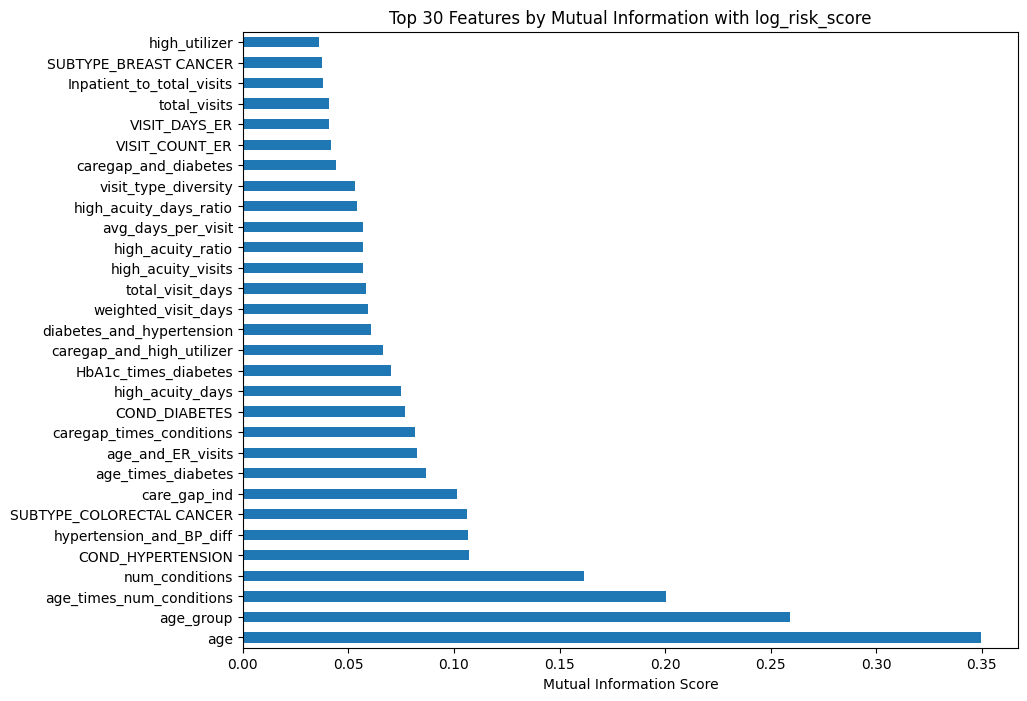

In [766]:
from sklearn.feature_selection import mutual_info_regression
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


final_df_cleaned = final_df.copy()
# --- Prepare Data ---
# 1. Define your features (X) and target (y)
features_to_exclude = ['patient_id', 'risk_score', 'log_risk_score']
valid_features_to_exclude = [col for col in features_to_exclude if col in final_df_cleaned.columns]
X = final_df_cleaned.drop(columns=valid_features_to_exclude)
y = final_df_cleaned['log_risk_score']

# 2. Identify which features are discrete (for the MI algorithm)
# We'll do this *before* encoding them all to numbers
discrete_features = []
for col in X.columns:
    # Treat object types and low-cardinality numbers as discrete
    if X[col].dtype == 'object' or pd.api.types.is_categorical_dtype(X[col]) or X[col].nunique() < 20:
        discrete_features.append(True)
    else:
        discrete_features.append(False)

print(f"Identified {sum(discrete_features)} discrete features.")

# 3. Robustly handle NaNs and Encode all columns to be numeric
for col in X.columns:
    if pd.api.types.is_numeric_dtype(X[col]) and not discrete_features[X.columns.get_loc(col)]:
        # A) For continuous numeric columns: Fill with median (more robust to outliers than 0)
        X[col] = X[col].fillna(X[col].median())
    else:
        # B) For discrete, categorical, or object columns:

        # If it's already a category dtype, add 'Missing' as a valid category
        if pd.api.types.is_categorical_dtype(X[col]):
            if 'Missing' not in X[col].cat.categories:
                X[col] = X[col].cat.add_categories(['Missing'])

        # Fill NaNs (for object or category) with the 'Missing' string
        X[col] = X[col].fillna('Missing')

        # Now, convert the entire column to category codes (numbers)
        X[col] = pd.Categorical(X[col]).codes

# At this point, all columns in X are numeric (int or float) and have no NaNs.

# --- Calculate MI ---
print("Calculating Mutual Information scores...")
mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=42)

# --- View Results ---
mi_series = pd.Series(mi_scores, index=X.columns)
mi_series = mi_series.sort_values(ascending=False)

print("\n--- Mutual Information Scores (Feature vs. Target) ---")
print(mi_series)

# Plot the top 30
plt.figure(figsize=(10, 8))
mi_series.head(30).plot(kind='barh')
plt.title('Top 30 Features by Mutual Information with log_risk_score')
plt.xlabel('Mutual Information Score')
plt.show()

In [767]:
%pip install catboost

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


Top 30 features by LightGBM importance: ['avg_visit_gap_days', 'age', 'age_and_ER_visits', 'age_times_num_conditions', 'weighted_visit_days', 'total_visits', 'high_acuity_days_ratio', 'high_acuity_days', 'age_times_diabetes', 'total_visit_days', 'VISIT_DAYS_INPATIENT', 'avg_days_per_visit', 'long_ER_ratio', 'COND_CANCER', 'VISIT_COUNT_URGENT CARE', 'Inpatient_to_total_visits', 'avg_days_inpatient', 'num_conditions', 'SUBTYPE_COLORECTAL CANCER', 'care_gap_ind', 'high_acuity_visits', 'COND_HYPERTENSION', 'visit_type_diversity', 'VISIT_COUNT_ER', 'LAB_TEST_HbA1c', 'ER_to_total_visits', 'SUBTYPE_BREAST CANCER', 'HbA1c_times_diabetes', 'COND_DIABETES', 'caregap_and_high_utilizer']


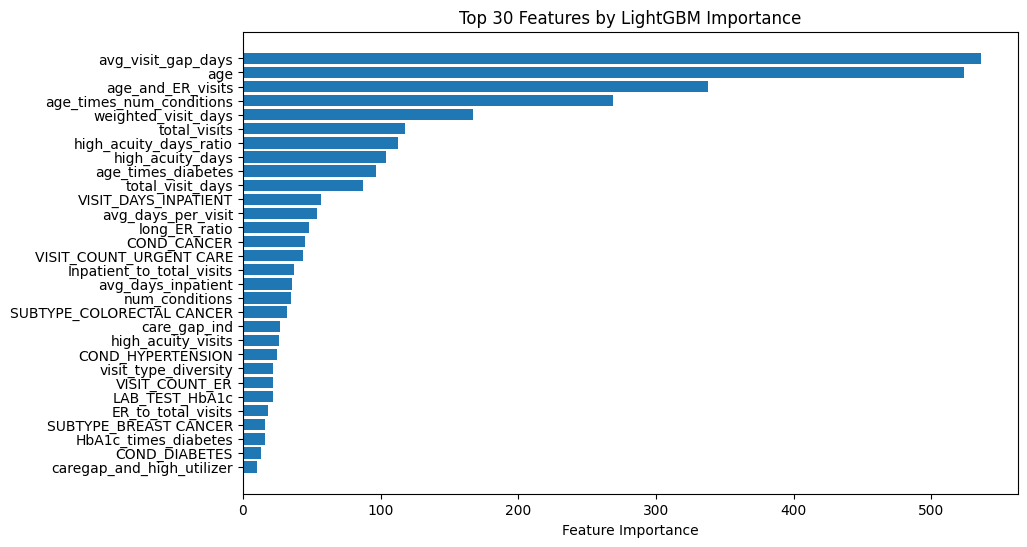

In [768]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Select numeric features (excluding target)
X = final_df_cleaned.select_dtypes(include=['int64','float64']).drop(columns=['log_risk_score','patient_id', 'risk_score'])
y = final_df_cleaned['log_risk_score']

# Split into train/test (optional, for importance calculation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LightGBM dataset
lgb_train = lgb.Dataset(X_train, y_train)

# Train a simple LightGBM regressor
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'seed': 42
}

model = lgb.train(params, lgb_train, num_boost_round=100)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importance()
}).sort_values(by='importance', ascending=False)

# Select top k features
k = 30
top_features_lgb = feature_importance.head(k)['feature'].tolist()
print("Top", k, "features by LightGBM importance:", top_features_lgb)

# Optional: Visualize
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.barh(feature_importance.head(k)['feature'], feature_importance.head(k)['importance'])
plt.xlabel('Feature Importance')
plt.title(f'Top {k} Features by LightGBM Importance')
plt.gca().invert_yaxis()
plt.show()


In [769]:
# --- Feature correlation matrix (numeric features only; excludes target) ---

import numpy as np
import pandas as pd

TARGET_COL = "risk_score"      # change if your target name differs
CORR_METHOD = "pearson"        # or "spearman"

# Copy and prep
df = final_df_cleaned.copy()

# Exclude target
X = df.drop(columns=[c for c in df.columns if c == TARGET_COL], errors="ignore")

# Treat booleans as ints and keep numeric columns
for c in X.columns:
    if X[c].dtype == bool:
        X[c] = X[c].astype(int)
work_num = X.select_dtypes(include=[np.number]).copy()

# Correlation matrix
corr = work_num.corr(method=CORR_METHOD)

# (Optional) upper triangle mask to avoid duplicates when listing pairs
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Preview
corr.head()  # or: display(corr)

,patient_id,LAB_TEST_HbA1c,LAB_TEST_SYSTOLIC BLOOD PRESSURE,LAB_TEST_DIASTOLIC BLOOD PRESSURE,SUBTYPE_BREAST CANCER,SUBTYPE_CHOLESTEROL,SUBTYPE_COLORECTAL CANCER,SUBTYPE_DIABETES,SUBTYPE_HYPERTENSION,care_gap_ind,...,caregap_and_diabetes,age_and_ER_visits,MAP,BP_category,HbA1c_category,high_acuity_visits,high_acuity_ratio,high_acuity_days,high_acuity_days_ratio,urgent_care_ratio
patient_id,1.000000,0.012352,0.001029,-0.005448,0.007842,-0.001217,-0.016519,0.000785,-0.022048,-0.007473,...,-0.013495,-0.005491,-0.005009,-0.003418,0.021723,-0.002823,-0.002823,0.002804,0.001064,-0.013364
LAB_TEST_HbA1c,0.012352,1.000000,-0.000522,-0.000404,-0.138362,-0.000516,-0.081367,-0.000421,-0.000596,0.130567,...,0.174248,-0.009046,-0.000617,-0.000720,0.919519,-0.006664,-0.006664,0.002880,-0.004069,-0.010430
LAB_TEST_SYSTOLIC BLOOD PRESSURE,0.001029,-0.000522,1.000000,-0.198415,-0.002216,-0.000380,-0.003642,-0.000310,-0.000438,0.096025,...,0.023977,0.007032,0.212540,0.883160,-0.000821,0.009364,0.009364,0.005475,-0.003912,0.024764
LAB_TEST_DIASTOLIC BLOOD PRESSURE,-0.005448,-0.000404,-0.198415,1.000000,-0.001713,-0.000293,-0.002815,-0.000240,-0.000339,0.074228,...,-0.002206,-0.005666,0.915553,0.238261,-0.000634,-0.006118,-0.006118,-0.003465,-0.007676,-0.001022
SUBTYPE_BREAST CANCER,0.007842,-0.138362,-0.002216,-0.001713,1.000000,0.113461,0.539980,-0.001788,0.047552,0.553962,...,0.376246,0.173562,-0.002618,-0.003053,-0.085094,0.170568,0.170568,0.193997,0.104397,0.036954


In [770]:
# --- List highly correlated pairs above a threshold ---

HIGH_CORR_THRESH = 0.8  # adjust as needed

# If 'upper' not defined from the previous block, compute it:
if "upper" not in globals():
    upper = work_num.corr(method=CORR_METHOD).where(
        np.triu(np.ones(work_num.shape[1]), k=1).astype(bool)
    )

high_pairs = (
    upper.stack()
         .rename("corr")
         .rename_axis(["feat1", "feat2"])
         .reset_index()
)
high_pairs["abs_corr"] = high_pairs["corr"].abs()
high_pairs = high_pairs.query("abs_corr >= @HIGH_CORR_THRESH") \
                       .sort_values("abs_corr", ascending=False) \
                       .reset_index(drop=True)

# Preview top pairs
# high_pairs.head(30)  # or: display(high_pairs)


In [771]:
# --- Drop a redundant feature from each high-corr pair
#     Keep the more predictive wrt target; else fewer NaNs; else higher variance ---

# y for predictiveness comparison; if missing, set y=None
y = df[TARGET_COL] if TARGET_COL in df.columns else None

def _choose_drop_feature(feat1, feat2, Xnum, yvec):
    s1, s2 = Xnum[feat1], Xnum[feat2]

    # (a) target predictiveness (absolute Pearson corr with target)
    if yvec is not None:
        yt = pd.to_numeric(yvec, errors="coerce")
        c1 = abs(pd.concat([s1, yt], axis=1).corr(method="pearson").iloc[0, 1])
        c2 = abs(pd.concat([s2, yt], axis=1).corr(method="pearson").iloc[0, 1])
        c1 = -1 if pd.isna(c1) else c1
        c2 = -1 if pd.isna(c2) else c2
        if c1 != c2:
            return feat2 if c1 > c2 else feat1  # drop the less predictive

    # (b) fewer NaNs
    n1, n2 = s1.isna().sum(), s2.isna().sum()
    if n1 != n2:
        return feat1 if n1 > n2 else feat2  # drop the one with MORE NaNs

    # (c) higher variance (keep higher variance; drop lower)
    v1, v2 = s1.var(skipna=True), s2.var(skipna=True)
    if not pd.isna(v1) and not pd.isna(v2) and v1 != v2:
        return feat2 if v1 > v2 else feat1

    # (d) tie-breaker: drop lexicographically later
    return max(feat1, feat2)

to_drop = []
seen_pairs = set()

for _, row in high_pairs.iterrows():
    f1, f2 = row["feat1"], row["feat2"]
    if f1 in to_drop or f2 in to_drop:
        continue
    key = tuple(sorted((f1, f2)))
    if key in seen_pairs:
        continue
    seen_pairs.add(key)
    drop_feat = _choose_drop_feature(f1, f2, work_num, y)
    to_drop.append(drop_feat)

# De-correlated feature set
X_decorrelated = work_num.drop(columns=to_drop, errors="ignore").copy()

# If you need target back:
final_for_model = (
    pd.concat([X_decorrelated, y], axis=1)
    if y is not None else X_decorrelated
)

# Quick summary
print("Dropped features due to high inter-feature correlation:", len(to_drop))
print(sorted(to_drop)[:50])
print("Original numeric features:", work_num.shape[1])
print("After dropping:", X_decorrelated.shape[1])


Dropped features due to high inter-feature correlation: 32
['BP_category', 'BP_ratio', 'COND_DIABETES', 'COND_HYPERTENSION', 'ER_to_total_visits', 'HbA1c_category', 'HbA1c_times_diabetes', 'LAB_TEST_DIASTOLIC BLOOD PRESSURE', 'MAP', 'VISIT_COUNT_ER', 'VISIT_COUNT_INPATIENT', 'VISIT_COUNT_URGENT CARE', 'VISIT_DAYS_ER', 'VISIT_DAYS_INPATIENT', 'VISIT_DAYS_URGENT CARE', 'age_and_ER_visits', 'age_times_diabetes', 'avg_days_ER', 'avg_days_inpatient', 'care_gap_ind', 'caregap_and_diabetes', 'high_BP', 'high_HbA1c', 'high_acuity_visits', 'high_utilizer', 'hypertension_and_BP_diff', 'hypertension_and_high_BP', 'num_conditions', 'total_visit_days', 'triple_threat', 'visit_type_diversity', 'weighted_visit_days']
Original numeric features: 66
After dropping: 34


In [775]:
# X_decorrelated = X_decorrelated[final_feature_columns]

In [776]:
# Save final feature list
final_feature_columns = X_decorrelated.columns.tolist()
final_feature_columns


['patient_id',
 'LAB_TEST_HbA1c',
 'LAB_TEST_SYSTOLIC BLOOD PRESSURE',
 'SUBTYPE_BREAST CANCER',
 'SUBTYPE_CHOLESTEROL',
 'SUBTYPE_COLORECTAL CANCER',
 'SUBTYPE_DIABETES',
 'SUBTYPE_HYPERTENSION',
 'COND_CANCER',
 'age',
 'log_risk_score',
 'visit_count_6m_0',
 'visit_count_6m_1',
 'visit_count_6m_2',
 'visit_count_6m_3',
 'total_visit_count',
 'avg_visit_gap_days',
 'total_visits',
 'avg_days_per_visit',
 'Inpatient_to_total_visits',
 'avg_days_urgent',
 'age_times_num_conditions',
 'BP_diff',
 'long_ER_ratio',
 'caregap_times_conditions',
 'diabetes_and_hypertension',
 'diabetes_and_cancer',
 'cancer_and_hypertension',
 'caregap_and_high_HbA1c',
 'caregap_and_high_utilizer',
 'high_acuity_ratio',
 'high_acuity_days',
 'high_acuity_days_ratio',
 'urgent_care_ratio']

In [ ]:
X_decorrelated=X_decorrelated.drop(columns='log_risk_score')


In [778]:
X_decorrelated

,patient_id,LAB_TEST_HbA1c,LAB_TEST_SYSTOLIC BLOOD PRESSURE,SUBTYPE_BREAST CANCER,SUBTYPE_CHOLESTEROL,SUBTYPE_COLORECTAL CANCER,SUBTYPE_DIABETES,SUBTYPE_HYPERTENSION,COND_CANCER,age,...,caregap_times_conditions,diabetes_and_hypertension,diabetes_and_cancer,cancer_and_hypertension,caregap_and_high_HbA1c,caregap_and_high_utilizer,high_acuity_ratio,high_acuity_days,high_acuity_days_ratio,urgent_care_ratio
0,1,5.7,120.0,0.0,0.0,0.0,0.0,0.0,0.0,55,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,19,5.7,120.0,0.0,0.0,0.0,0.0,0.0,1.0,57,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,40,5.7,120.0,0.0,0.0,0.0,0.0,0.0,0.0,68,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,46,5.7,120.0,0.0,0.0,0.0,0.0,0.0,0.0,53,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,58,5.7,120.0,0.0,0.0,0.0,0.0,0.0,0.0,60,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,82098,5.7,120.0,0.0,0.0,0.0,0.0,0.0,0.0,42,...,0.0,0.0,0.0,0.0,0.0,0.0,2000000.0,2.0,1.0,0.0
7996,82117,5.7,120.0,0.0,0.0,0.0,0.0,0.0,0.0,45,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000000.0
7997,82120,5.7,120.0,0.0,0.0,0.0,0.0,0.0,0.0,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7998,82130,5.7,120.0,0.0,0.0,0.0,0.0,0.0,0.0,49,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000000.0


In [ ]:
from sklearn.impute import SimpleImputer
X = X_decorrelated.copy()
y = final_df_cleaned.loc[X.index, 'log_risk_score'].copy()

print(f"X shape: {X.shape} | y length: {len(y)}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# Handle NaNs for sklearn RF (and to keep things consistent across models)
imp = SimpleImputer(strategy="median")
X_train_i = imp.fit_transform(X_train)
X_test_i  = imp.transform(X_test)

# -------------------------
# 2) Define models
# -------------------------
models = {
    # 'LightGBM': lgb.LGBMRegressor(objective='regression', n_estimators=500, learning_rate=0.05, random_state=42),
    # 'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.05,
    #                             max_depth=6, subsample=0.9, colsample_bytree=0.9, random_state=42, n_jobs=-1),
    'CatBoost': CatBoostRegressor(iterations=500, learning_rate=0.05, loss_function='RMSE', verbose=0, random_state=42),
    # 'RandomForest': RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
}

# -------------------------
# 3) Train, predict, evaluate on ORIGINAL scale
# -------------------------
results = []

for name, model in models.items():
    # Train on imputed matrices (CatBoost/LightGBM/XGB handle NaNs, but we keep it uniform)
    model.fit(X_train_i, y_train)

    # Predict on log scale
    y_pred_log = model.predict(X_test_i)

    # Convert back to original risk score scale
    # If you used log1p for target, replace exp with expm1 for both y_pred and y_test.
    y_pred_orig = np.exp(y_pred_log)
    y_test_orig = np.exp(y_test)

    rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
    r2 = r2_score(y_test_orig, y_pred_orig)

    results.append({'Model': name, 'RMSE': rmse, 'R2': r2})
    print(f"{name} -> Original Scale RMSE: {rmse:.4f}, R2: {r2:.4f}")

# -------------------------
# 4) Compare all models
# -------------------------
results_df = pd.DataFrame(results).sort_values(by='RMSE', ascending=True).reset_index(drop=True)
print("\nModel Comparison on Original Risk Score Scale:")
print(results_df.to_string(index=False))


X shape: (8000, 33) | y length: 8000
CatBoost -> Original Scale RMSE: 1.5050, R2: 0.5079

Model Comparison on Original Risk Score Scale:
   Model     RMSE       R2
CatBoost 1.504953 0.507912


In [833]:
from sklearn.impute import SimpleImputer
X = final_df.copy()
# y = final_df_cleaned.loc[X.index, 'log_risk_score'].copy()

In [ ]:

# model.save_model("catboost_model.cbm")

from catboost import CatBoostRegressor

model = CatBoostRegressor()
model.load_model("catboost_model.cbm")

y_pred_log = model.predict(X)
y_pred = np.exp(y_pred_log)  # convert back to original scale

risk_output = pd.DataFrame({
    'patient_id': patient_df['patient_id'],
    'predicted_risk_score': y_pred
})

risk_output.to_csv('Prediction.csv', index=False)

In [104]:
%pip install sentence-transformers

# ==== 0) Imports & setup ====
import re
import numpy as np
import pandas as pd

# Embeddings
from sentence_transformers import SentenceTransformer

# Clustering
try:
    import hdbscan
    HAVE_HDBSCAN = True
except Exception:
    HAVE_HDBSCAN = False
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances

# -----------------------------------------------------------
# 1) Normalize diagnosis strings (simple, robust text cleanup)
# -----------------------------------------------------------
def normalize_dx(s: str) -> str:
    if pd.isna(s):
        return ""
    s = s.lower().strip()
    # remove quotes/commas/brackets etc.
    s = re.sub(r"[\[\]\(\),;:\"'\/\\]+", " ", s)
    # remove common filler words
    s = re.sub(r"\b(unspecified|other|initial encounter|without|with|and|type|region)\b", " ", s)
    # drop laterality and basic stopwords that cause fragmentation
    s = re.sub(r"\b(left|right|bilateral|acute|chronic|primary|secondary)\b", " ", s)
    # de-pluralize simple plurals (naive)
    s = re.sub(r"\b(\w+?)s\b", r"\1", s)
    # collapse spaces
    s = re.sub(r"\s+", " ", s).strip()
    return s

visit_df = visit_df.copy()
visit_df["dx_norm"] = visit_df["prncpl_diag_nm"].astype(str).map(normalize_dx)

# Keep a deduped vocabulary
dx_vocab = (
    visit_df.loc[visit_df["dx_norm"].str.len() > 0, "dx_norm"]
    .drop_duplicates()
    .reset_index(drop=True)
)
print(f"Unique normalized diagnoses: {len(dx_vocab)}")

# -----------------------------------------
# 2) Embed the diagnosis vocabulary (SentBERT)
# -----------------------------------------
# Small, fast, surprisingly strong baseline model
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
emb = model.encode(
    dx_vocab.tolist(),
    batch_size=256,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True,  # cosine-ready
)
print("Embeddings shape:", emb.shape)

# ---------------------------------------------------
# 3) Cluster similar strings → cluster ids per term
#    Prefer HDBSCAN; fallback to Agglomerative
# ---------------------------------------------------
if HAVE_HDBSCAN:
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=5,         # tune per dataset size
        min_samples=2,              # more/less conservative
        metric="euclidean",         # embeddings are normalized → euclidean ~ cosine
        cluster_selection_epsilon=0.05,
        cluster_selection_method="eom",
        prediction_data=False
    )
    labels = clusterer.fit_predict(emb)
else:
    # Agglomerative fallback with cosine distance threshold
    # Choose a threshold; smaller → more clusters, larger → fewer clusters
    D = pairwise_distances(emb, metric="cosine")
    # We set distance_threshold; n_clusters must be None for this mode
    clusterer = AgglomerativeClustering(
        n_clusters=None,
        affinity="precomputed",
        linkage="average",
        distance_threshold=0.1  # tune; ~cosine similarity 0.80
    )
    labels = clusterer.fit_predict(D)

# labels: -1 means "noise" in HDBSCAN; in Agglo everything gets a cluster
labels = pd.Series(labels, index=dx_vocab.index, name="dx_cluster")

# Map vocab → cluster
dx_map = pd.DataFrame({"dx_norm": dx_vocab, "dx_cluster": labels.values})

# Optional: pick a human-readable representative for each cluster
# (the most frequent original string in that cluster)
tmp = (
    visit_df.merge(dx_map, on="dx_norm", how="left")
            .groupby(["dx_cluster", "dx_norm"])
            .size()
            .rename("count")
            .reset_index()
)
rep = tmp.sort_values(["dx_cluster", "count"], ascending=[True, False]) \
         .drop_duplicates("dx_cluster") \
         .rename(columns={"dx_norm": "dx_representative"})[["dx_cluster", "dx_representative"]]

dx_map = dx_map.merge(rep, on="dx_cluster", how="left")

# Persist mapping if you want to inspect/edit:
# dx_map.to_csv("diagnosis_cluster_mapping.csv", index=False)

# ------------------------------------------------------
# 4) Attach clusters to visits and make per-patient features
# ------------------------------------------------------
vis = visit_df.merge(dx_map[["dx_norm", "dx_cluster"]], on="dx_norm", how="left")

# Put HDBSCAN noise into its own bucket (optional)
vis["dx_cluster"] = vis["dx_cluster"].fillna(-1).astype(int)

# Count visits per (patient, cluster)
dx_feat = (
    vis.groupby(["patient_id", "dx_cluster"])
       .size()
       .unstack(fill_value=0)
       .add_prefix("DXC_")
       .reset_index()
)

print("Diagnosis feature matrix shape (wide):", dx_feat.shape)

# ------------------------------------------------------
# 5) Join with your modeling feature matrix (X_decorrelated)
# ------------------------------------------------------
# Ensure patient_id is the index in both (or merge on column)
if "patient_id" not in X_decorrelated.index.names and "patient_id" in X_decorrelated.columns:
    X_base = X_decorrelated.set_index("patient_id")
else:
    X_base = X_decorrelated.copy()
    if "patient_id" not in X_base.index.names:
        raise ValueError("Please index X_decorrelated by patient_id or include a 'patient_id' column.")

dx_feat = dx_feat.set_index("patient_id")

# Align and fill missing
X_with_dx = X_base.join(dx_feat, how="left").fillna(0)

print("Original X_decorrelated:", X_base.shape)
print("X_with_dx:", X_with_dx.shape)

# If you keep only top-K clusters to control width:
K = 50  # tune
cluster_totals = dx_feat.sum(0).sort_values(ascending=False)
topk_cols = cluster_totals.index[:K]
X_with_dx_topk = X_base.join(dx_feat[topk_cols], how="left").fillna(0)
print("X_with_dx_topk:", X_with_dx_topk.shape)

# Optionally, keep both:
#   - X_with_dx (all clusters)
#   - X_with_dx_topk (top-K only)


  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached urllib3-2.5.0-py3-none-any.whl.metadata (6.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 2.7 MB/s  0:00:04a 0:00:01m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 3.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 3.1 MB/s  0:00:01m 3.1 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 3.8 MB/s  0:00:003.7 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.6/806.6 kB 5.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.3/800.3 kB 3.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.8/899.8 MB 16.4 MB/s  0:01:05 eta 0:00:010:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 10.6 MB/s  0:00:43 eta 0:00:010:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 6.4 MB/s  0:00:01 6.1 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 8.1 

Batches: 100%|██████████| 5/5 [00:00<00:00, 16.18it/s]

Embeddings shape: (1233, 384)


TypeError: AgglomerativeClustering.__init__() got an unexpected keyword argument 'affinity'

In [95]:
import re

def normalize_dx(s: str) -> str:
    if pd.isna(s):
        return ""
    s = s.lower().strip()
    # remove quotes/commas/brackets etc.
    s = re.sub(r"[\[\]\(\),;:\"'\/\\]+", " ", s)
    # remove common filler words
    s = re.sub(r"\b(unspecified|other|initial encounter|without|with|and|type|region)\b", " ", s)
    # drop laterality and basic stopwords that cause fragmentation
    s = re.sub(r"\b(left|right|bilateral|acute|chronic|primary|secondary)\b", " ", s)
    # de-pluralize simple plurals (naive)
    s = re.sub(r"\b(\w+?)s\b", r"\1", s)
    # collapse spaces
    s = re.sub(r"\s+", " ", s).strip()
    return s

visit_df = visit_df.copy()
visit_df["dx_norm"] = visit_df["prncpl_diag_nm"].astype(str).map(normalize_dx)

# Keep a deduped vocabulary
dx_vocab = (
    visit_df.loc[visit_df["dx_norm"].str.len() > 0, "dx_norm"]
    .drop_duplicates()
    .reset_index(drop=True)
)
print(f"Unique normalized diagnoses: {len(dx_vocab)}")


Unique normalized diagnoses: 1233


In [308]:
# # -------------------------
# # 1) Choose feature matrix
# # -------------------------
# if "X_with_dx_topk" in globals():
#     X = X_with_dx_topk.copy()
#     src = "X_with_dx_topk"
# elif "X_with_dx" in globals():
#     X = X_with_dx.copy()
#     src = "X_with_dx"
# else:
#     X = X_decorrelated.copy()
#     src = "X_decorrelated"

# # Ensure we can align by patient_id
# def ensure_index_by_patient_id(df):
#     if isinstance(df, pd.DataFrame):
#         if "patient_id" in df.index.names:
#             return df
#         if "patient_id" in df.columns:
#             return df.set_index("patient_id")
#     return df  # assume already indexed appropriately

# X = ensure_index_by_patient_id(X)
# ffc = final_df_cleaned.copy()
# ffc = ensure_index_by_patient_id(ffc)

# # Build y and align X,y on their common patient_ids
# y_all = ffc["log_risk_score"]
# common_idx = X.index.intersection(y_all.index)

# X = X.loc[common_idx].sort_index()
# y = y_all.loc[common_idx].sort_index()

# # Optional: drop rows with missing y
# mask = y.notna()
# X = X.loc[mask]
# y = y.loc[mask]

# print(f"Using features from: {src}")
# print(f"Aligned rows: {len(common_idx)} | After dropping NaN y: {mask.sum()}")
# print(f"X shape: {X.shape} | y length: {len(y)}")

# # -------------------------
# # 2) Train/test split & impute
# # -------------------------
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.20, random_state=42
# )

# imp = SimpleImputer(strategy="median")
# X_train_i = imp.fit_transform(X_train)
# X_test_i  = imp.transform(X_test)

# # -------------------------
# # 3) Define models
# # -------------------------
# models = {
#     'LightGBM': lgb.LGBMRegressor(objective='regression', n_estimators=500, learning_rate=0.05, random_state=42),
#     'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.05,
#                                 max_depth=6, subsample=0.9, colsample_bytree=0.9, random_state=42, n_jobs=-1),
#     'CatBoost': CatBoostRegressor(iterations=500, learning_rate=0.05, loss_function='RMSE', verbose=0, random_state=42),
#     'RandomForest': RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
# }

# # -------------------------
# # 4) Train, predict, evaluate on ORIGINAL scale
# # -------------------------
# results = []

# for name, model in models.items():
#     model.fit(X_train_i, y_train)
#     y_pred_log = model.predict(X_test_i)

#     # If target used log1p, replace exp with expm1 for both lines below
#     y_pred_orig = np.exp(y_pred_log)
#     y_test_orig = np.exp(y_test)

#     rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
#     r2 = r2_score(y_test_orig, y_pred_orig)

#     results.append({'Model': name, 'RMSE': rmse, 'R2': r2})
#     print(f"{name} -> Original Scale RMSE: {rmse:.4f}, R2: {r2:.4f}")

# # -------------------------
# # 5) Compare all models
# # -------------------------
# results_df = pd.DataFrame(results).sort_values(by='RMSE', ascending=True).reset_index(drop=True)
# print("\nModel Comparison on Original Risk Score Scale:")
# print(results_df.to_string(index=False))

In [91]:
%pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.8/27.8 MB 2.1 MB/s  0:00:13a 0:00:01m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [gensim]━━━━━━━━━━━ 2/3 [gensim]
Note: you may need to restart the kernel to use updated packages.


In [96]:
# --- Replace Step 2 (SentenceTransformer) with GloVe/word2vec embeddings via gensim ---

import re
import numpy as np
import pandas as pd
from collections import Counter
from gensim.utils import simple_preprocess
import gensim.downloader as api
from sklearn.preprocessing import normalize

# 1) Load a pre-trained word embedding model (pick ONE)
# Small & easy:
wv = api.load("glove-wiki-gigaword-100")        # 100-dim GloVe
# Alternative (bigger, slower, but strong):
# wv = api.load("word2vec-google-news-300")     # 300-dim word2vec (1.6GB)

dim = wv.vector_size

# 2) Tokenize normalized diagnoses (dx_vocab is from your previous step)
docs = [simple_preprocess(s, deacc=True, min_len=2) for s in dx_vocab.tolist()]

# 3) Build simple IDF from this corpus (for weighting)
N = len(docs)
df_counts = Counter()
for tokens in set(map(tuple, docs)):  # unique doc rows (optional)
    pass
# More precise DF: count once per document for each token
df_counts = Counter()
for tokens in docs:
    for t in set(tokens):
        df_counts[t] += 1

idf = {t: np.log((N + 1) / (df + 1)) + 1.0 for t, df in df_counts.items()}

# 4) Make IDF-weighted average embedding for each diagnosis
def sent_embed(tokens):
    vecs = []
    weights = []
    for t in tokens:
        if t in wv.key_to_index:         # known word
            vecs.append(wv.get_vector(t))
            weights.append(idf.get(t, 1.0))
    if not vecs:                         # all OOV → zero vector
        return np.zeros(dim, dtype=np.float32)
    V = np.vstack(vecs)
    w = np.asarray(weights, dtype=np.float32)[:, None]  # (k,1)
    return (V * w).sum(axis=0) / (w.sum() + 1e-9)

emb = np.vstack([sent_embed(tokens) for tokens in docs]).astype(np.float32)

# 5) L2-normalize (so cosine distance ≈ euclidean on the unit sphere)
emb = normalize(emb, norm="l2", axis=1)

print("Embeddings shape (GloVe/word2vec):", emb.shape)

# 6) Proceed with your existing clustering block unchanged
# (HDBSCAN with metric='euclidean' OR Agglomerative on cosine distances)
# Example (Agglomerative):
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering

D = pairwise_distances(emb, metric="cosine")
clusterer = AgglomerativeClustering(
    n_clusters=None,
    metric="precomputed",   # use 'metric' (affinity is deprecated)
    linkage="average",
    distance_threshold=0.20  # tune: lower -> more clusters, higher -> fewer clusters
)
labels = clusterer.fit_predict(D)

Embeddings shape (GloVe/word2vec): (1233, 100)


In [97]:
# === Build X_with_dx and X_with_dx_topk from clustering labels ===
# Assumes you already have:
# - dx_vocab (list/Series of unique normalized diagnosis strings)
# - labels  (np.array of cluster ids aligned with dx_vocab)
# - visit_df with columns: patient_id, prncpl_diag_nm  (and optionally dx_norm)
# - X_decorrelated (patient-level features; has 'patient_id' as a column or index)

import re
import numpy as np
import pandas as pd

# 1) Ensure normalized text exists on visit_df (reuse your earlier normalize_dx if available)
try:
    normalize_dx
except NameError:
    def normalize_dx(s: str) -> str:
        if pd.isna(s): return ""
        s = s.lower().strip()
        s = re.sub(r"[\[\]\(\),;:\"'\/\\]+", " ", s)
        s = re.sub(r"\b(unspecified|other|initial encounter|without|with|and|type|region)\b", " ", s)
        s = re.sub(r"\b(left|right|bilateral|acute|chronic|primary|secondary)\b", " ", s)
        s = re.sub(r"\b(\w+?)s\b", r"\1", s)
        s = re.sub(r"\s+", " ", s).strip()
        return s

visit_df = visit_df.copy()
if "dx_norm" not in visit_df.columns:
    visit_df["dx_norm"] = visit_df["prncpl_diag_nm"].astype(str).map(normalize_dx)

# 2) Map vocab -> cluster id
dx_map = pd.DataFrame({
    "dx_norm": pd.Series(dx_vocab),
    "dx_cluster": pd.Series(labels).astype(int)
})

# (Optional) choose a human-readable representative per cluster
tmp = (
    visit_df.merge(dx_map, on="dx_norm", how="left")
            .groupby(["dx_cluster", "dx_norm"])
            .size()
            .rename("count")
            .reset_index()
)
rep = (tmp.sort_values(["dx_cluster","count"], ascending=[True, False])
          .drop_duplicates("dx_cluster")
          .rename(columns={"dx_norm":"dx_representative"})[["dx_cluster","dx_representative"]])
dx_map = dx_map.merge(rep, on="dx_cluster", how="left")

# 3) Attach clusters to visits
vis = visit_df.merge(dx_map[["dx_norm","dx_cluster"]], on="dx_norm", how="left")
# If your clustering produced noise labels (e.g., HDBSCAN -1), keep them or fill with -1
vis["dx_cluster"] = vis["dx_cluster"].fillna(-1).astype(int)

# 4) Pivot to per-patient cluster counts
dx_feat = (
    vis.groupby(["patient_id","dx_cluster"])
       .size()
       .unstack(fill_value=0)
       .add_prefix("DXC_")
       .reset_index()
)

# 5) Join with your base matrix X_decorrelated
if "patient_id" in getattr(X_decorrelated, "columns", []):
    X_base = X_decorrelated.set_index("patient_id").copy()
else:
    X_base = X_decorrelated.copy()
    if "patient_id" not in (X_base.index.names or []):
        raise ValueError("X_decorrelated must have 'patient_id' as a column or index.")

dx_feat = dx_feat.set_index("patient_id")
X_with_dx = X_base.join(dx_feat, how="left").fillna(0)

print("Original X_decorrelated:", X_base.shape)
print("X_with_dx:", X_with_dx.shape)

# 6) Build top-K cluster feature matrix (to control width)
K = 50  # tune this
cluster_totals = dx_feat.sum(axis=0).sort_values(ascending=False)
topk_cols = cluster_totals.index[:K]
X_with_dx_topk = X_base.join(dx_feat[topk_cols], how="left").fillna(0)

print("Top-K cluster columns:", (topk_cols))
print("X_with_dx_topk:", X_with_dx_topk.shape)


Original X_decorrelated: (8000, 31)
X_with_dx: (8000, 573)
Top-K cluster columns: Index(['DXC_38', 'DXC_36', 'DXC_13', 'DXC_307', 'DXC_79', 'DXC_275', 'DXC_85',
       'DXC_12', 'DXC_535', 'DXC_3', 'DXC_195', 'DXC_40', 'DXC_28', 'DXC_14',
       'DXC_21', 'DXC_92', 'DXC_124', 'DXC_423', 'DXC_6', 'DXC_76', 'DXC_30',
       'DXC_455', 'DXC_102', 'DXC_105', 'DXC_511', 'DXC_517', 'DXC_89',
       'DXC_271', 'DXC_235', 'DXC_48', 'DXC_299', 'DXC_94', 'DXC_503',
       'DXC_61', 'DXC_273', 'DXC_253', 'DXC_7', 'DXC_59', 'DXC_495', 'DXC_20',
       'DXC_401', 'DXC_492', 'DXC_374', 'DXC_197', 'DXC_18', 'DXC_122',
       'DXC_292', 'DXC_361', 'DXC_53', 'DXC_298'],
      dtype='object', name='dx_cluster')
X_with_dx_topk: (8000, 81)


In [98]:
# =========================
# Train & evaluate models after adding DX cluster features (robust alignment)
# =========================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score

# Models
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

# -------------------------
# 1) Choose feature matrix
# -------------------------
if "X_with_dx_topk" in globals():
    X = X_with_dx_topk.copy()
    src = "X_with_dx_topk"
elif "X_with_dx" in globals():
    X = X_with_dx.copy()
    src = "X_with_dx"
else:
    X = X_decorrelated.copy()
    src = "X_decorrelated"

# Ensure we can align by patient_id
def ensure_index_by_patient_id(df):
    if isinstance(df, pd.DataFrame):
        if "patient_id" in (df.index.names or []):
            return df
        if "patient_id" in df.columns:
            return df.set_index("patient_id")
    return df  # assume already indexed appropriately

X = ensure_index_by_patient_id(X)
ffc = ensure_index_by_patient_id(final_df_cleaned.copy())

# Build y and align X,y on their common patient_ids
y_all = ffc["log_risk_score"]
common_idx = X.index.intersection(y_all.index)

X = X.loc[common_idx].sort_index()
y = y_all.loc[common_idx].sort_index()

# Optional: drop rows with missing y
mask = y.notna()
X = X.loc[mask]
y = y.loc[mask]

print(f"Using features from: {src}")
print(f"Aligned rows: {len(common_idx)} | After dropping NaN y: {mask.sum()}")
print(f"X shape: {X.shape} | y length: {len(y)}")

# -------------------------
# 2) Train/test split & impute
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

imp = SimpleImputer(strategy="median")
X_train_i = imp.fit_transform(X_train)
X_test_i  = imp.transform(X_test)

# -------------------------
# 3) Define models
# -------------------------
models = {
    'LightGBM': lgb.LGBMRegressor(objective='regression', n_estimators=500, learning_rate=0.05, random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.05,
                                max_depth=6, subsample=0.9, colsample_bytree=0.9, random_state=42, n_jobs=-1),
    'CatBoost': CatBoostRegressor(iterations=500, learning_rate=0.05, loss_function='RMSE', verbose=0, random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
}

# -------------------------
# 4) Train, predict, evaluate on ORIGINAL scale
# -------------------------
results = []

for name, model in models.items():
    model.fit(X_train_i, y_train)
    y_pred_log = model.predict(X_test_i)

    # If target used log1p, replace exp with expm1 for both lines below
    y_pred_orig = np.exp(y_pred_log)
    y_test_orig = np.exp(y_test)

    rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
    r2 = r2_score(y_test_orig, y_pred_orig)

    results.append({'Model': name, 'RMSE': rmse, 'R2': r2})
    print(f"{name} -> Original Scale RMSE: {rmse:.4f}, R2: {r2:.4f}")

# -------------------------
# 5) Compare all models
# -------------------------
results_df = pd.DataFrame(results).sort_values(by='RMSE', ascending=True).reset_index(drop=True)
print("\nModel Comparison on Original Risk Score Scale:")
print(results_df.to_string(index=False))


Using features from: X_with_dx_topk
Aligned rows: 8000 | After dropping NaN y: 8000
X shape: (8000, 81) | y length: 8000


/home/nikhil/hilabs/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM -> Original Scale RMSE: 1.5769, R2: 0.4598
XGBoost -> Original Scale RMSE: 1.5781, R2: 0.4589
CatBoost -> Original Scale RMSE: 1.5216, R2: 0.4970
RandomForest -> Original Scale RMSE: 1.5741, R2: 0.4617

Model Comparison on Original Risk Score Scale:
       Model     RMSE       R2
    CatBoost 1.521618 0.496953
RandomForest 1.574104 0.461651
    LightGBM 1.576874 0.459754
     XGBoost 1.578146 0.458883


In [101]:
# ==============================
# SHAP analysis on trained model
# Drop 10 least important features
# ==============================
%pip install shap
import numpy as np
import pandas as pd
import shap

# --- 0) Choose which trained model to explain ---
# Use one of: 'LightGBM', 'XGBoost', 'CatBoost', 'RandomForest'
MODEL_NAME = 'LightGBM'

# Refit the chosen model on the imputed training data (keeps things explicit/reproducible)
model = models[MODEL_NAME]
model.fit(X_train_i, y_train)

# --- 1) Build DataFrames after imputation so SHAP has feature names ---
X_train_i_df = pd.DataFrame(X_train_i, columns=X.columns, index=X_train.index)
X_test_i_df  = pd.DataFrame(X_test_i,  columns=X.columns, index=X_test.index)

# --- 2) Compute SHAP values ---
# TreeExplainer works for tree-based models (LGBM/XGB/CatBoost/RF)
explainer = shap.TreeExplainer(model)
# For regression, shap_values is (n_samples, n_features)
shap_values = explainer.shap_values(X_test_i_df)

# Ensure we have the right shape if library returns list (older CatBoost/XGB versions)
if isinstance(shap_values, list):
    # pick the single output for regression
    shap_values = shap_values[0]

# --- 3) Mean |SHAP| per feature (global importance) ---
mean_abs_shap = np.abs(shap_values).mean(axis=0)
shap_importance = pd.Series(mean_abs_shap, index=X_test_i_df.columns).sort_values(ascending=False)

print("\nTop 15 features by mean |SHAP|:")
print(shap_importance.head(15).to_string())

print("\nBottom 15 features by mean |SHAP|:")
print(shap_importance.tail(15).to_string())

# --- 4) Pick the 10 least important features & drop them from the full X ---
bottom_10 = shap_importance.tail(10).index.tolist()
print("\nWill drop these 10 lowest-importance features:")
print(bottom_10)

X_shap_reduced = X.drop(columns=bottom_10, errors="ignore").copy()
print(f"\nOriginal feature count: {X.shape[1]} -> After drop: {X_shap_reduced.shape[1]}")

# If you want to continue training with reduced features:
# Re-split using the same indices to keep comparability
X_train_r = X_shap_reduced.loc[X_train.index]
X_test_r  = X_shap_reduced.loc[X_test.index]

# Re-impute (since columns changed)
from sklearn.impute import SimpleImputer
imp_r = SimpleImputer(strategy="median")
X_train_r_i = imp_r.fit_transform(X_train_r)
X_test_r_i  = imp_r.transform(X_test_r)

# (Optional) quick re-eval with the same model
model_r = models[MODEL_NAME]
model_r.fit(X_train_r_i, y_train)
y_pred_log_r = model_r.predict(X_test_r_i)

# If target was log1p, replace exp by expm1
y_pred_orig_r = np.exp(y_pred_log_r)
y_test_orig   = np.exp(y_test)

from sklearn.metrics import mean_squared_error, r2_score
rmse_r = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig_r))
r2_r   = r2_score(y_test_orig, y_pred_orig_r)
print(f"\n[{MODEL_NAME} after dropping 10 features] -> RMSE: {rmse_r:.4f}, R2: {r2_r:.4f}")

# --- (Optional) SHAP plots ---
shap.summary_plot(shap_values, X_test_i_df, plot_type="bar", max_display=30)
shap.summary_plot(shap_values, X_test_i_df, max_display=30)


  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.0 MB/s  0:00:00m 5.8 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 12.4 MB/s  0:00:002.3 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s  0:00:04 eta 0:00:010:00:01
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [shap]━━━━━━ 5/6 [shap] [numba]
Note: you may need to restart the kernel to use updated packages.


/home/nikhil/hilabs/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ValueError: Shape of passed values is (6400, 58), indices imply (6400, 81)

In [99]:
# ============================================================
# WOE/IV-based feature selection + correlation pruning + train
# ============================================================
# Uses:
#   - X_with_dx_topk (preferred) or X_with_dx or X_decorrelated
#   - final_df_cleaned['log_risk_score'] (regression target)
# Steps:
#   1) Align X with y; derive binary label for WOE/IV from original risk score (median split)
#   2) Compute IV for each feature (numeric & categorical)
#   3) Drop N lowest-IV features
#   4) Prune redundant features via high inter-feature correlation (|r| >= THRESH), keeping higher-IV one
#   5) Train models (LGBM/XGB/CatBoost/RF) on remaining features; score on ORIGINAL scale
# ============================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score

# Models
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

# -------------------------
# 0) Choose feature matrix
# -------------------------
if "X_with_dx_topk" in globals():
    X = X_with_dx_topk.copy(); src = "X_with_dx_topk"
elif "X_with_dx" in globals():
    X = X_with_dx.copy(); src = "X_with_dx"
else:
    X = X_decorrelated.copy(); src = "X_decorrelated"

def ensure_index_by_patient_id(df):
    if isinstance(df, pd.DataFrame):
        if "patient_id" in (df.index.names or []): return df
        if "patient_id" in df.columns: return df.set_index("patient_id")
    return df

X = ensure_index_by_patient_id(X)
ffc = ensure_index_by_patient_id(final_df_cleaned.copy())

# Align
y_log = ffc["log_risk_score"]
common_idx = X.index.intersection(y_log.index)
X = X.loc[common_idx].sort_index()
y_log = y_log.loc[common_idx].sort_index()

# Build ORIGINAL-scale target for eval & a BINARY label for WOE/IV
y_orig = np.exp(y_log)            # if you used log1p, switch to np.expm1
thr = y_orig.median()             # binary split threshold (median). Change to .quantile(0.75) if desired
y_bin = (y_orig >= thr).astype(int)

print(f"[INFO] Using {src} | X: {X.shape} | y_orig: {y_orig.shape} | Positive rate: {y_bin.mean():.3f}")

# -------------------------
# 1) WOE/IV utilities
# -------------------------
EPS = 1e-9

def _woe_iv_from_counts(evt, nevt):
    """evt/nevt are arrays of event/non-event counts per bin/category."""
    evt = np.asarray(evt, dtype=float)
    nevt = np.asarray(nevt, dtype=float)
    total_evt = evt.sum(); total_nevt = nevt.sum()
    if total_evt == 0 or total_nevt == 0:
        # degenerate case: return zeros to avoid nuking all features
        return np.zeros_like(evt), 0.0
    p_evt = evt / total_evt + EPS
    p_nevt = nevt / total_nevt + EPS
    woe = np.log(p_evt / p_nevt)
    iv = ((p_evt - p_nevt) * woe).sum()
    return woe, float(iv)

def iv_for_series(x, y_bin, max_bins=10):
    """Compute IV for a single feature x against binary label y_bin.
       Numeric → quantile binning; Categorical → category grouping (top 50 cats, rest='__OTHER__')."""
    s = pd.Series(x)
    # Handle all-NaN or constant
    if s.dropna().nunique() <= 1:
        return 0.0

    if pd.api.types.is_numeric_dtype(s):
        # Quantile bins with fallbacks if not enough unique values
        try:
            # deduplicate edges
            q = np.linspace(0, 1, num=max_bins+1)
            bins = pd.qcut(s, q=q, duplicates="drop")
        except Exception:
            # fallback: uniform bins
            try:
                bins = pd.cut(s, bins=min(max_bins, int(s.nunique())))
            except Exception:
                return 0.0
        grp = pd.DataFrame({"bin": bins, "y": y_bin}).dropna(subset=["bin"])
        ct = grp.groupby("bin")["y"].agg(evt="sum", cnt="count")
        ct["nevt"] = ct["cnt"] - ct["evt"]
        _, iv = _woe_iv_from_counts(ct["evt"].values, ct["nevt"].values)
        return iv

    else:
        # Categorical: cap high cardinality
        vc = s.astype(str).value_counts(dropna=False)
        top = set(vc.index[:50])  # cap to top 50 categories
        cat = s.astype(str).where(s.astype(str).isin(top), "__OTHER__")
        grp = pd.DataFrame({"cat": cat, "y": y_bin}).dropna(subset=["cat"])
        ct = grp.groupby("cat")["y"].agg(evt="sum", cnt="count")
        ct["nevt"] = ct["cnt"] - ct["evt"]
        _, iv = _woe_iv_from_counts(ct["evt"].values, ct["nevt"].values)
        return iv

# -------------------------
# 2) Compute IV for all features
# -------------------------
iv_scores = {}
for col in X.columns:
    try:
        iv_scores[col] = iv_for_series(X[col], y_bin, max_bins=10)
    except Exception:
        iv_scores[col] = 0.0

iv_series = pd.Series(iv_scores).sort_values(ascending=False)
print("\n[INFO] Top 15 IV features:")
print(iv_series.head(15).to_string())
print("\n[INFO] Bottom 15 IV features:")
print(iv_series.tail(15).to_string())

# -------------------------
# 3) Drop N lowest-IV features
# -------------------------
N_DROP = 15  # change as needed
lowest_features = iv_series.tail(N_DROP).index.tolist()
print(f"\n[INFO] Dropping {N_DROP} lowest-IV features:")
print(lowest_features)
X_iv = X.drop(columns=lowest_features, errors="ignore")

# -------------------------
# 4) Correlation pruning among remaining numeric features
#    - compute Pearson on numeric cols
#    - for each pair with |r| >= THRESH, drop the one with LOWER IV
# -------------------------
THRESH = 0.7
num_df = X_iv.select_dtypes(include=[np.number]).copy()

if num_df.shape[1] >= 2:
    corr = num_df.corr(method="pearson")
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    high_pairs = (
        upper.stack()
             .rename("corr")
             .rename_axis(["f1","f2"])
             .reset_index()
    )
    high_pairs["abs_corr"] = high_pairs["corr"].abs()
    high_pairs = high_pairs.query("abs_corr >= @THRESH").sort_values("abs_corr", ascending=False)

    to_drop_corr = []
    kept = set(X_iv.columns)
    for _, row in high_pairs.iterrows():
        f1, f2 = row["f1"], row["f2"]
        # skip if either already dropped
        if f1 not in kept or f2 not in kept:
            continue
        iv1 = iv_series.get(f1, 0.0)
        iv2 = iv_series.get(f2, 0.0)
        # keep higher-IV, drop lower-IV
        if iv1 >= iv2:
            drop_feat = f2
        else:
            drop_feat = f1
        to_drop_corr.append(drop_feat)
        kept.remove(drop_feat)

    print(f"\n[INFO] Correlation pruning: dropping {len(to_drop_corr)} redundant features (|r| >= {THRESH})")
    X_final = X_iv.drop(columns=to_drop_corr, errors="ignore")
else:
    print("\n[INFO] Skipped correlation pruning (not enough numeric features).")
    X_final = X_iv.copy()

print(f"[INFO] Feature count: original {X.shape[1]} -> after IV drop {X_iv.shape[1]} -> after corr prune {X_final.shape[1]}")

# -------------------------
# 5) Train/test split & impute
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_log.loc[X_final.index], test_size=0.20, random_state=42
)

imp = SimpleImputer(strategy="median")
X_train_i = imp.fit_transform(X_train)
X_test_i  = imp.transform(X_test)

# -------------------------
# 6) Define & train models; evaluate on ORIGINAL scale
# -------------------------
models = {
    'LightGBM': lgb.LGBMRegressor(objective='regression', n_estimators=500, learning_rate=0.05, random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.05,
                                max_depth=6, subsample=0.9, colsample_bytree=0.9, random_state=42, n_jobs=-1),
    'CatBoost': CatBoostRegressor(iterations=500, learning_rate=0.05, loss_function='RMSE', verbose=0, random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
}

results = []
for name, model in models.items():
    model.fit(X_train_i, y_train)
    y_pred_log = model.predict(X_test_i)

    # If you used log1p for target, change to np.expm1
    y_pred_orig = np.exp(y_pred_log)
    y_test_orig = np.exp(y_test)

    rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
    r2 = r2_score(y_test_orig, y_pred_orig)

    results.append({"Model": name, "RMSE": rmse, "R2": r2})
    print(f"{name} -> Original Scale RMSE: {rmse:.4f}, R2: {r2:.4f}")

results_df = pd.DataFrame(results).sort_values(by="RMSE").reset_index(drop=True)
print("\nModel Comparison on Original Risk Score Scale (after WOE/IV + Corr prune):")
print(results_df.to_string(index=False))


[INFO] Using X_with_dx_topk | X: (8000, 81) | y_orig: (8000,) | Positive rate: 0.502

[INFO] Top 15 IV features:
age                                 1.325616
age_times_num_conditions            1.084887
high_acuity_days_ratio              0.157340
high_acuity_days                    0.154150
high_acuity_visits                  0.133092
total_visit_count                   0.122858
avg_days_per_visit                  0.094155
avg_visit_gap_days                  0.055426
LAB_TEST_HbA1c                      0.025652
VISIT_COUNT_URGENT CARE             0.015548
LAB_TEST_SYSTOLIC BLOOD PRESSURE    0.001594
BP_diff                             0.001594
avg_days_urgent                     0.000170
COND_CANCER                         0.000000
SUBTYPE_HYPERTENSION                0.000000

[INFO] Bottom 15 IV features:
DXC_253    0.0
DXC_7      0.0
DXC_59     0.0
DXC_495    0.0
DXC_20     0.0
DXC_401    0.0
DXC_492    0.0
DXC_374    0.0
DXC_197    0.0
DXC_18     0.0
DXC_122    0.0
DXC_292    0.0
D

/tmp/ipykernel_28417/2881343706.py:99: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ct = grp.groupby("bin")["y"].agg(evt="sum", cnt="count")
/tmp/ipykernel_28417/2881343706.py:99: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ct = grp.groupby("bin")["y"].agg(evt="sum", cnt="count")
/tmp/ipykernel_28417/2881343706.py:99: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ct = grp.groupby("bin")["y"].agg(evt="sum", cnt="count"


[INFO] Correlation pruning: dropping 8 redundant features (|r| >= 0.7)
[INFO] Feature count: original 81 -> after IV drop 66 -> after corr prune 58


/home/nikhil/hilabs/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM -> Original Scale RMSE: 1.6326, R2: 0.4209
XGBoost -> Original Scale RMSE: 1.6764, R2: 0.3894
CatBoost -> Original Scale RMSE: 1.5474, R2: 0.4797
RandomForest -> Original Scale RMSE: 1.6414, R2: 0.4147

Model Comparison on Original Risk Score Scale (after WOE/IV + Corr prune):
       Model     RMSE       R2
    CatBoost 1.547429 0.479742
    LightGBM 1.632631 0.420874
RandomForest 1.641358 0.414666
     XGBoost 1.676439 0.389377


In [100]:
# ============================================================
# WOE/IV feature selection + correlation pruning + train/eval (with MAE)
# Works with X_with_dx_topk / X_with_dx / X_decorrelated and final_df_cleaned['log_risk_score']
# ============================================================

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Models
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

# -------------------------
# 0) Choose feature matrix & align by patient_id
# -------------------------
if "X_with_dx_topk" in globals():
    X = X_with_dx_topk.copy(); src = "X_with_dx_topk"
elif "X_with_dx" in globals():
    X = X_with_dx.copy(); src = "X_with_dx"
else:
    X = X_decorrelated.copy(); src = "X_decorrelated"

def ensure_index_by_patient_id(df: pd.DataFrame) -> pd.DataFrame:
    if isinstance(df, pd.DataFrame):
        if "patient_id" in (df.index.names or []):
            return df
        if "patient_id" in df.columns:
            return df.set_index("patient_id")
    return df

X = ensure_index_by_patient_id(X)
ffc = ensure_index_by_patient_id(final_df_cleaned.copy())

# Targets
y_log = ffc["log_risk_score"]
common_idx = X.index.intersection(y_log.index)
X = X.loc[common_idx].sort_index()
y_log = y_log.loc[common_idx].sort_index()

# Original-scale target for metrics, and binary target for WOE/IV
y_orig = np.exp(y_log)           # if you used log1p earlier, switch to: np.expm1(y_log)
y_bin = (y_orig >= y_orig.median()).astype(int)

print(f"[INFO] Source: {src} | X: {X.shape} | Pos rate (WOE/IV label): {y_bin.mean():.3f}")

# -------------------------
# 1) WOE/IV helpers
# -------------------------
EPS = 1e-9

def _woe_iv_from_counts(evt, nevt):
    evt = np.asarray(evt, dtype=float)
    nevt = np.asarray(nevt, dtype=float)
    tot_e, tot_ne = evt.sum(), nevt.sum()
    if tot_e <= 0 or tot_ne <= 0:
        return np.zeros_like(evt), 0.0
    p_e = evt / tot_e + EPS
    p_ne = nevt / tot_ne + EPS
    woe = np.log(p_e / p_ne)
    iv = float(((p_e - p_ne) * woe).sum())
    return woe, iv

def iv_for_series(x: pd.Series, yb: pd.Series, max_bins: int = 10) -> float:
    s = pd.Series(x)
    # constant or all-NaN
    if s.dropna().nunique() <= 1:
        return 0.0

    if pd.api.types.is_numeric_dtype(s):
        # quantile binning
        try:
            bins = pd.qcut(s, q=np.linspace(0, 1, max_bins + 1), duplicates="drop")
        except Exception:
            # fallback to uniform binning
            try:
                bins = pd.cut(s, bins=min(max_bins, int(s.dropna().nunique())))
            except Exception:
                return 0.0
        dfb = pd.DataFrame({"bin": bins, "y": yb}).dropna(subset=["bin"])
        ct = dfb.groupby("bin")["y"].agg(evt="sum", cnt="count")
        ct["nevt"] = ct["cnt"] - ct["evt"]
        _, iv = _woe_iv_from_counts(ct["evt"].values, ct["nevt"].values)
        return iv
    else:
        # categorical: cap high cardinality
        vc = s.astype(str).value_counts(dropna=False)
        top = set(vc.index[:50])
        cat = s.astype(str).where(s.astype(str).isin(top), "__OTHER__")
        dfb = pd.DataFrame({"cat": cat, "y": yb}).dropna(subset=["cat"])
        ct = dfb.groupby("cat")["y"].agg(evt="sum", cnt="count")
        ct["nevt"] = ct["cnt"] - ct["evt"]
        _, iv = _woe_iv_from_counts(ct["evt"].values, ct["nevt"].values)
        return iv

# -------------------------
# 2) Compute IV for all features
# -------------------------
iv_scores = {}
for col in X.columns:
    try:
        iv_scores[col] = iv_for_series(X[col], y_bin, max_bins=10)
    except Exception:
        iv_scores[col] = 0.0

iv_series = pd.Series(iv_scores).sort_values(ascending=False)
print("\n[INFO] Top 12 IV features:")
print(iv_series.head(12).to_string())
print("\n[INFO] Bottom 12 IV features:")
print(iv_series.tail(12).to_string())

# -------------------------
# 3) Drop lowest-IV features
# -------------------------
N_DROP = 15  # drop 10 lowest-IV as requested
to_drop_iv = iv_series.tail(N_DROP).index.tolist()
print(f"\n[INFO] Dropping {N_DROP} lowest-IV features:\n{to_drop_iv}")
X_iv = X.drop(columns=to_drop_iv, errors="ignore")

# -------------------------
# 4) Correlation pruning (among numeric), keep higher-IV
# -------------------------
THRESH = 0.7  # |corr| threshold

num_df = X_iv.select_dtypes(include=[np.number])
to_drop_corr = []

if num_df.shape[1] >= 2:
    corr = num_df.corr(method="pearson")
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    pairs = (
        upper.stack()
             .rename("corr")
             .rename_axis(["f1", "f2"])
             .reset_index()
    )
    pairs["abs_corr"] = pairs["corr"].abs()
    high_pairs = pairs.query("abs_corr >= @THRESH").sort_values("abs_corr", ascending=False)

    kept = set(X_iv.columns)
    for _, row in high_pairs.iterrows():
        f1, f2 = row["f1"], row["f2"]
        if f1 not in kept or f2 not in kept:
            continue
        iv1 = iv_series.get(f1, 0.0)
        iv2 = iv_series.get(f2, 0.0)
        drop_feat = f2 if iv1 >= iv2 else f1
        to_drop_corr.append(drop_feat)
        kept.remove(drop_feat)

    X_final = X_iv.drop(columns=to_drop_corr, errors="ignore")
    print(f"\n[INFO] Correlation pruning dropped {len(to_drop_corr)} features (|r| >= {THRESH}):\n{sorted(set(to_drop_corr))}")
else:
    X_final = X_iv.copy()
    print("\n[INFO] Skipped correlation pruning (not enough numeric features).")

print(f"\n[INFO] Feature counts -> original: {X.shape[1]} | after IV: {X_iv.shape[1]} | after corr: {X_final.shape[1]}")

# -------------------------
# 5) Train/test split & impute
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_log.loc[X_final.index], test_size=0.20, random_state=42
)

imp = SimpleImputer(strategy="median")
X_train_i = imp.fit_transform(X_train)
X_test_i  = imp.transform(X_test)

# -------------------------
# 6) Define, train, evaluate (MAE, RMSE, R2 on ORIGINAL scale)
# -------------------------
models = {
    'LightGBM': lgb.LGBMRegressor(objective='regression', n_estimators=500, learning_rate=0.05, random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.05,
                                max_depth=6, subsample=0.9, colsample_bytree=0.9, random_state=42, n_jobs=-1),
    'CatBoost': CatBoostRegressor(iterations=500, learning_rate=0.05, loss_function='RMSE', verbose=0, random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
}

results = []
for name, model in models.items():
    model.fit(X_train_i, y_train)
    y_pred_log = model.predict(X_test_i)

    # Back-transform to original scale
    y_pred_orig = np.exp(y_pred_log)   # if log1p was used to create y, switch to np.expm1
    y_test_orig = np.exp(y_test)

    mae  = mean_absolute_error(y_test_orig, y_pred_orig)
    rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
    r2   = r2_score(y_test_orig, y_pred_orig)

    results.append({"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2})
    print(f"{name} -> MAE: {mae:.4f} | RMSE: {rmse:.4f} | R2: {r2:.4f}")

results_df = pd.DataFrame(results).sort_values(by="MAE").reset_index(drop=True)
print("\nModel Comparison on Original Risk Score Scale (after WOE/IV + Corr prune):")
print(results_df.to_string(index=False))


[INFO] Source: X_with_dx_topk | X: (8000, 81) | Pos rate (WOE/IV label): 0.502

[INFO] Top 12 IV features:
age                                 1.325616
age_times_num_conditions            1.084887
high_acuity_days_ratio              0.157340
high_acuity_days                    0.154150
high_acuity_visits                  0.133092
total_visit_count                   0.122858
avg_days_per_visit                  0.094155
avg_visit_gap_days                  0.055426
LAB_TEST_HbA1c                      0.025652
VISIT_COUNT_URGENT CARE             0.015548
LAB_TEST_SYSTOLIC BLOOD PRESSURE    0.001594
BP_diff                             0.001594

[INFO] Bottom 12 IV features:
DXC_495    0.0
DXC_20     0.0
DXC_401    0.0
DXC_492    0.0
DXC_374    0.0
DXC_197    0.0
DXC_18     0.0
DXC_122    0.0
DXC_292    0.0
DXC_361    0.0
DXC_53     0.0
DXC_298    0.0

[INFO] Dropping 15 lowest-IV features:
['DXC_253', 'DXC_7', 'DXC_59', 'DXC_495', 'DXC_20', 'DXC_401', 'DXC_492', 'DXC_374', 'DXC_197', 'DXC_1

/tmp/ipykernel_28417/566809289.py:86: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ct = dfb.groupby("bin")["y"].agg(evt="sum", cnt="count")
/tmp/ipykernel_28417/566809289.py:86: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ct = dfb.groupby("bin")["y"].agg(evt="sum", cnt="count")
/tmp/ipykernel_28417/566809289.py:86: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ct = dfb.groupby("bin")["y"].agg(evt="sum", cnt="count")
/


[INFO] Correlation pruning dropped 8 features (|r| >= 0.7):
['BP_diff', 'VISIT_COUNT_URGENT CARE', 'avg_days_per_visit', 'caregap_and_high_utilizer', 'caregap_times_conditions', 'diabetes_and_hypertension', 'high_acuity_visits', 'visit_count_6m_1']

[INFO] Feature counts -> original: 81 | after IV: 66 | after corr: 58


/home/nikhil/hilabs/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM -> MAE: 0.7873 | RMSE: 1.6326 | R2: 0.4209
XGBoost -> MAE: 0.7805 | RMSE: 1.6764 | R2: 0.3894
CatBoost -> MAE: 0.7608 | RMSE: 1.5474 | R2: 0.4797
RandomForest -> MAE: 0.7972 | RMSE: 1.6414 | R2: 0.4147

Model Comparison on Original Risk Score Scale (after WOE/IV + Corr prune):
       Model      MAE     RMSE       R2
    CatBoost 0.760831 1.547429 0.479742
     XGBoost 0.780497 1.676439 0.389377
    LightGBM 0.787261 1.632631 0.420874
RandomForest 0.797195 1.641358 0.414666
